## 0. Imports

In [1]:
import os
import re
import cv2 
import subprocess
import time
import uuid
from datetime import datetime
from pathlib import Path

import csv
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from six import BytesIO

from object_detection.builders import model_builder
from object_detection.utils import config_util
from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util

In [ ]:
# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
pipeline_config = './myModules/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config'

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

print("Model was successfully built")

In [2]:
#Checking for gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.10.1


In [3]:
random.seed(42)
np.random.seed(21)
tf.compat.v1.random.set_random_seed(42)

## 1. Dataset

In [ ]:
def readTrafficSignsTrain(rootpath, cache_path):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments:
        rootpath: path to the traffic sign data, for example './GTSRB/Training'
        cache_path: path to the cached DataFrame file, default is 'traffic_signs_data.pkl'
    Returns:
        DataFrame containing labels, image shapes, ROIs, and image paths
    '''
    
    if os.path.exists(cache_path):
        print(f"Loading: {cache_path}")
        return pd.read_pickle(cache_path)

    data = []
    # loop over all 43 classes
    for c in range(0, 43):
        prefix = f"{rootpath}/{c:05d}/"  # subdirectory for class
        gtFile = open(prefix + f'GT-{c:05d}.csv')  # annotations file
        gtReader = csv.reader(gtFile, delimiter=';')  # csv parser for annotations file
        next(gtReader)  # skip header

        # loop over all images in current annotations file
        for row in gtReader:
            img_path = prefix + row[0]
            img = plt.imread(img_path)  # load image

            label = int(row[7])  # the 8th column is the label
            height = img.shape[0]  # height of the image
            width = img.shape[1]  # width of the image
            #channels = img.shape[2] if len(img.shape) > 2 else 1  # channels of the image (default to 1 if grayscale)
            roi_x1 = int(row[3])  # ROI X1 coordinate
            roi_y1 = int(row[4])  # ROI Y1 coordinate
            roi_x2 = int(row[5])  # ROI X2 coordinate
            roi_y2 = int(row[6])  # ROI Y2 coordinate

            data.append([width, height, roi_x1, roi_y1, roi_x2, roi_y2, img_path, label])

        gtFile.close()

    df = pd.DataFrame(data, columns=['Width', 'Height','Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'Path', 'Label'])
    
    df.to_pickle(cache_path)
    print(f"Dataframe saved in: {cache_path}")
    
    return df

In [ ]:
df_train_cache = readTrafficSignsTrain(train_path, "./myModules/data/df_train_raw.pkl")

In [ ]:
# 1:'Speed limit (30km/h)', 
# 2:'Speed limit (50km/h)',
# 12:'Priority road', 
# 14:'Stop', 
# 17:'No entry',
# 41: 'Ende des Überholverbots',

In [4]:
SAMPLE_SIZE_TRAIN = 50 # Default: 50 Images of each class excluding values in :id_mapping. Used for Trainset
SAMPLE_SIZE_TEST = 10 # Default: 10 Images of each class excluding values in :id_mapping . Used for Testset

IMAGE_WIDTH = 280 # Image width in pixels to resize 
IMAGE_HEIGHT = 280 # Image height in pixels to resize 

train_path = './GTSRB/Final_Training/Images'
test_path = './GTSRB/Final_Test/Images'

id_mapping = {1: 1, 2: 2, 12: 3, 14: 4, 17: 5}
unknown_label = 6

### Dataset Setup

In [ ]:
def readTrafficSignsTrain(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns: DataFrame containing labels, image shapes, ROIs, and image paths'''
    
    # Initialisiere eine leere Liste für die Daten
    data = []

    # loop over all 43 classes
    for c in range(0, 43):
        prefix = f"{rootpath}/{c:05d}/"  # subdirectory for class
        gtFile = open(prefix + f'GT-{c:05d}.csv')  # annotations file
        gtReader = csv.reader(gtFile, delimiter=';')  # csv parser for annotations file
        next(gtReader)  # skip header

        # loop over all images in current annotations file
        for row in gtReader:
            img_path = prefix + row[0]
            img = plt.imread(img_path)  # load image

            label = int(row[7])  # the 8th column is the label
            height = img.shape[0]  # height of the image
            width = img.shape[1]  # width of the image
            #channels = img.shape[2] if len(img.shape) > 2 else 1  # channels of the image (default to 1 if grayscale)
            roi_x1 = int(row[3])  # ROI X1 coordinate
            roi_y1 = int(row[4])  # ROI Y1 coordinate
            roi_x2 = int(row[5])  # ROI X2 coordinate
            roi_y2 = int(row[6])  # ROI Y2 coordinate

            # Füge die Daten als Zeile hinzu
            data.append([width, height, roi_x1, roi_y1, roi_x2, roi_y2, img_path, label])

        gtFile.close()

    # Erstelle ein DataFrame aus der Liste
    df = pd.DataFrame(data, columns=['Width', 'Height','Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'Path', 'Label'])
    return df

In [ ]:
def readTrafficSignsTest(rootpath):
    '''Reads the final test data for the German Traffic Sign Recognition Benchmark.
    Arguments: path to the final test data, for example './GTSRB/Final_Test/Images'
    Returns: DataFrame with image data, labels, image shapes, and ROI
    '''
    # Pfad zur CSV-Datei
    csv_file = os.path.join(rootpath, 'GT-final_test_gt.csv')
    
    # Lade die CSV-Datei
    df = pd.read_csv(csv_file, delimiter=';')
    
    # Liste zum Speichern der Daten
    data = []
    
    # Schleife über alle Zeilen der CSV-Datei
    for _, row in df.iterrows():
        img_path = os.path.join(rootpath, row['Filename'])
        img = plt.imread(img_path)  # Lade das Bild
        
        if img is not None:
            label = int(row['ClassId'])
            height, width, channels = img.shape
            roi_x1 = int(row['Roi.X1'])
            roi_y1 = int(row['Roi.Y1'])
            roi_x2 = int(row['Roi.X2'])
            roi_y2 = int(row['Roi.Y2'])
            
            # Füge die Daten als Zeile hinzu
            data.append([width, height, roi_x1, roi_y1, roi_x2, roi_y2, img_path, label])
        else:
            print(f"Bild {img_path} konnte nicht geladen werden.")
    
    # Erstelle ein DataFrame aus der Liste
    df_test = pd.DataFrame(data, columns=['Width', 'Height','Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'Path', 'Label'])
    return df_test

In [ ]:
def load_image_into_numpy_array(path):
    image = Image.open(path)
    image = image.resize((280, 280))  # Resize to 280x280
    return np.array(image).astype(np.uint8)

In [ ]:
def reassign_labels(df, selected_labels, unknown_label, sample_size):
    """
    Reassign labels in the dataframe according to selected_labels.
    Keep all rows for the labels in selected_labels.
    For remaining labels, sample a specified number of rows and reassign them to unknown_label.

    Parameters:
    df (pd.DataFrame): The input dataframe with a column named 'Label'.
    selected_labels (dict): A dictionary mapping old labels to new labels.
    unknown_label (int): The label to assign to the remaining sampled rows.
    sample_size (int): The number of rows to sample for each remaining label. Default is 15.

    Returns:
    pd.DataFrame: A new dataframe with reassigned labels.
    """
    new_df = pd.DataFrame()

    for old_label, new_label in selected_labels.items():
        label_df = df[df['Label'] == old_label].copy()
        label_df['Label'] = new_label
        new_df = pd.concat([new_df, label_df])

    unique_labels = df['Label'].unique()
    remaining_labels = [label for label in unique_labels if label not in selected_labels]

    for label in remaining_labels:
        label_df = df[df['Label'] == label]
        if len(label_df) > sample_size:
            selected_rows = label_df.sample(n=sample_size, random_state=42)
        else:
            selected_rows = label_df
        selected_rows['Label'] = unknown_label
        new_df = pd.concat([new_df, selected_rows])

    new_df.reset_index(drop=True, inplace=True)

    return new_df

### 2.1 Dataset export 

In [ ]:
df_train_raw = readTrafficSignsTrain(train_path)
df_train = pd.DataFrame()
df_train = df_train_raw.copy()

In [ ]:
df_test_raw = readTrafficSignsTest(test_path)
df_test = pd.DataFrame()
df_test = df_test_raw.copy()

In [ ]:
df_final_train = reassign_labels(df_train, id_mapping, unknown_label, SAMPLE_SIZE_TRAIN)
df_final_test = reassign_labels(df_test, id_mapping, unknown_label, SAMPLE_SIZE_TEST)

In [ ]:
df_final_test.info()

In [ ]:
df_final_train.info()

### 2.2 Verfify Dataset

In [ ]:
%matplotlib inline
short_classes = { 1: 'Geschwindigkeitsbegrenzung (30km/h)', 
                  2: 'Geschwindigkeitsbegrenzung (50km/h)', 
                  3: 'Vorrangstraße', 
                  4: 'Stop', 
                  5: 'Einfahrt verboten',
                  6: 'Unbekannt'}

In [ ]:
image_paths_to_display = df_final_train['Path'].tolist()
image_paths_to_display = random.sample(image_paths_to_display, min(len(image_paths_to_display), 100))

plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths_to_display):
    image_np = load_image_into_numpy_array(image_path)  # Funktion, um Bild in ein numpy array zu laden
    plt.subplot(10, 10, i + 1)
    plt.imshow(image_np)
    plt.axis('off')

plt.tight_layout()

In [ ]:
image_paths_to_display = df_final_test['Path'].tolist()
image_paths_to_display = random.sample(image_paths_to_display, min(len(image_paths_to_display), 100))

plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths_to_display):
    image_np = load_image_into_numpy_array(image_path)  # Funktion, um Bild in ein numpy array zu laden
    plt.subplot(10, 10, i + 1)
    plt.imshow(image_np)
    plt.axis('off')

plt.tight_layout()

In [ ]:
unknown_label_df = df_final_train[df_final_train['Label'] == 6]

# Wähle zufällig 100 Bilder aus
image_paths_to_display = unknown_label_df['Path'].tolist()
image_paths_to_display = random.sample(image_paths_to_display, min(len(image_paths_to_display), 100))

# Plotten der ausgewählten Bilder
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths_to_display):
    image_np = load_image_into_numpy_array(image_path)  # Funktion, um Bild in ein numpy array zu laden
    plt.subplot(10, 10, i + 1)
    plt.imshow(image_np)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
label_counts_final = df_final_train['Label'].value_counts().sort_index()

num_classes = len(label_counts_final)

label_counts_named_final = {short_classes[key]: value for key, value in label_counts_final.items()}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts_named_final.keys()), y=list(label_counts_named_final.values()), palette='viridis')
plt.xlabel('Verkehrsschilder')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Verkehrsschilder im Trainingsdatensatz')
plt.xticks(rotation=45, ha='right')  # Optional: Rotiere die Beschriftungen für bessere Lesbarkeit
plt.tight_layout()
plt.show()

In [ ]:
label_counts_test = df_final_test['Label'].value_counts().sort_index()
#label_counts_train = df_train_short['Label'].value_counts().sort_index()

num_classes = len(label_counts_test)

In [ ]:
label_counts_named_train = {short_classes[key]: value for key, value in label_counts_train.items()}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts_named_train.keys()), y=list(label_counts_named_train.values()), palette='viridis')
plt.xlabel('Verkehrsschilder')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Verkehrsschilder im Trainingsdatensatz')
plt.xticks(rotation=45, ha='right')  # Optional: Rotiere die Beschriftungen für bessere Lesbarkeit
plt.tight_layout()
plt.show()

In [ ]:
label_counts_named_test = {short_classes[key]: value for key, value in label_counts_test.items()}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts_named_test.keys()), y=list(label_counts_named_test.values()), palette='viridis')
plt.xlabel('Verkehrsschilder')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Verkehrsschilder im Testdatensatz')
plt.xticks(rotation=45, ha='right')  # Optional: Rotiere die Beschriftungen für bessere Lesbarkeit
plt.tight_layout()
plt.show()

### 2.3 Create Tf-records

In [ ]:
def create_tf_example(row):
    img_path = row['Path']
    # Lade das Bild und konvertiere es in ein kompatibles Format (z.B. JPEG)
    image = Image.open(img_path)
    image = image.convert("RGB")
    with io.BytesIO() as output:
        image.save(output, format="JPEG")
        encoded_jpg = output.getvalue()

    width, height = image.size

    filename = row['Path'].encode('utf8')
    image_format = b'jpeg'  # Ändere dies entsprechend des konvertierten Bildformats
    xmins = [row['Roi.X1'] / width]
    xmaxs = [row['Roi.X2'] / width]
    ymins = [row['Roi.Y1'] / height]
    ymaxs = [row['Roi.Y2'] / height]
    classes_text = [str(row['Label']).encode('utf8')]
    classes = [int(row['Label'])]

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_jpg])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_format])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }))
    return tf_example

In [ ]:
def create_tf_record(df, output_path):
    writer = tf.io.TFRecordWriter(output_path)
    for _, row in df.iterrows():
        tf_example = create_tf_example(row)
        writer.write(tf_example.SerializeToString())
    writer.close()

In [ ]:
create_tf_record(df_final_train, './myModules/records/train.record')
create_tf_record(df_final_test, './myModules/records/test.record')

### 2.4 Verify Tensord records

In [8]:
def parse_tf_example(serialized_example):
    feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/source_id': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/xmax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/class/text': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(serialized_example, feature_description)

In [9]:
def read_tfrecord(record_file):
    raw_dataset = tf.data.TFRecordDataset(record_file)
    parsed_dataset = raw_dataset.map(parse_tf_example)
    return parsed_dataset

In [10]:
def display_image_at_index(parsed_dataset, index):
    for i, tf_example in enumerate(parsed_dataset):
        if i == index:
            height = tf_example['image/height'].numpy()
            width = tf_example['image/width'].numpy()
            encoded_image = tf_example['image/encoded'].numpy()
            xmin = tf_example['image/object/bbox/xmin'].numpy()
            xmax = tf_example['image/object/bbox/xmax'].numpy()
            ymin = tf_example['image/object/bbox/ymin'].numpy()
            ymax = tf_example['image/object/bbox/ymax'].numpy()
            label = tf_example['image/object/class/label'].numpy()

            image = tf.image.decode_jpeg(encoded_image)
            image_np = image.numpy()

            plt.figure(figsize=(4, 4))
            plt.imshow(image_np)
            plt.title(f'Label: {label}')

            # Draw the bounding box
            plt.gca().add_patch(plt.Rectangle((xmin * width, ymin * height), 
                                              (xmax - xmin) * width, (ymax - ymin) * height,
                                              edgecolor='green', facecolor='none', linewidth=2))
            plt.axis('off')
            plt.show()
            break

In [11]:
train_record = read_tfrecord('./myModules/records/train.record')
test_record = read_tfrecord('./myModules/records/test.record')

In [14]:
%matplotlib inline

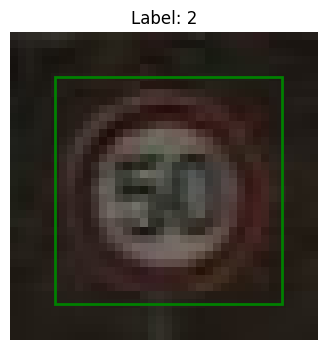

In [16]:
display_image_at_index(test_record, 888)

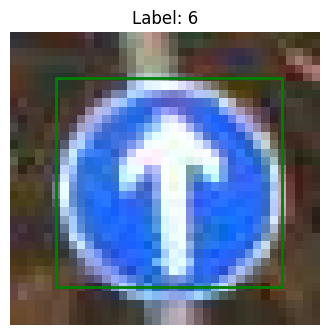

In [19]:
display_image_at_index(train_record, 10000)

## 3. Model

In [5]:
BASE_MODEL = "ssd_resnet101_v1_fpn_640x640_coco17_tpu-8"
MODEL_NAME = "ssd_test"

In [ ]:
model {
  ssd {
    num_classes: 6
    image_resizer {
      fixed_shape_resizer {
        height: 640
        width: 640
      }
    }
    feature_extractor {
      type: "ssd_resnet101_v1_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 0.0004
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.03
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.997
          scale: true
          epsilon: 0.001
        }
      }
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    box_predictor {
      weight_shared_convolutional_box_predictor {
        conv_hyperparams {
          regularizer {
            l2_regularizer {
              weight: 0.0004
            }
          }
          initializer {
            random_normal_initializer {
              mean: 0.0
              stddev: 0.01
            }
          }
          activation: RELU_6
          batch_norm {
            decay: 0.997
            scale: true
            epsilon: 0.001
          }
        }
        depth: 256
        num_layers_before_predictor: 4
        kernel_size: 3
        class_prediction_bias_init: -4.6
      }
    }
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
        anchor_scale: 4.0
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        scales_per_octave: 2
      }
    }
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
        use_static_shapes: false
      }
      score_converter: SIGMOID
    }
    normalize_loss_by_num_matches: true
    loss {
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_loss {
        weighted_sigmoid_focal {
          gamma: 2.0
          alpha: 0.25
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    encode_background_as_zeros: true
    normalize_loc_loss_by_codesize: true
    inplace_batchnorm_update: true
    freeze_batchnorm: false
  }
}
train_config {
  batch_size: 4
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_adjust_brightness {
      max_delta: 0.2
    }
  }
  data_augmentation_options {
    random_adjust_contrast {
      min_delta: 0.8
      max_delta: 1.2
    }
  }
  data_augmentation_options {
    random_rotation90 {
    }
  }
  data_augmentation_options {
    random_crop_image {
      min_object_covered: 0.0
      min_aspect_ratio: 0.75
      max_aspect_ratio: 1.33
      min_area: 0.75
      max_area: 1.0
      overlap_thresh: 0.0
    }
  }
  data_augmentation_options {
    random_jpeg_quality {
      min_jpeg_quality: 50
      max_jpeg_quality: 100
    }
  }
  sync_replicas: true
  optimizer {
    momentum_optimizer {
      learning_rate {
        cosine_decay_learning_rate {
          learning_rate_base: 0.01
          total_steps: 25000
          warmup_learning_rate: 0.003333
          warmup_steps: 2000
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  fine_tune_checkpoint: "./base_models/ssd/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0"
  num_steps: 8000
  startup_delay_steps: 0.0
  replicas_to_aggregate: 8
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
  fine_tune_checkpoint_type: "detection"
  use_bfloat16: false
  fine_tune_checkpoint_version: V2
}
train_input_reader {
  label_map_path: "./myModules/label_map_short.pbtxt"
  tf_record_input_reader {
    input_path: "./myModules/records/train.record"
  }
}
eval_config {
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
}
eval_input_reader {
  label_map_path: "./myModules/label_map_short.pbtxt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "./myModules/records/train.record"
  }
}


In [6]:
BATCH_SIZE = 2
NUM_CLASSES = 6
NUM_STEPS = 8000
NUM_EVAL_STEPS = 1000
use_bfloat16 = False # Use bfloat16 True for TPU

NOTES = ""

In [ ]:
def count_length(df):
    count_images = len(df)
    labels_count = df['Label'].value_counts()

    sorted_labels_count = labels_count.sort_index()
    return sorted_labels_count.tolist(), count_images

In [ ]:
def log_model_info(batch, classes, steps, eval_steps, name, bfloat16, pipeline, 
                   checkpoint_path, labelmap, train_record, test_record, config, 
                   trained_model, train_time, df_train, df_test, notes):
    
    
    test_count, test_len = count_length(df_test)
    train_count, train_len = count_length(df_train)   
    log_contents = f"""
Trainingparameters:
    BATCH_SIZE = {batch} # Cannot be higher than 2-4 (lack of ressources)
    NUM_CLASSES = {classes} # Total number of classes to train is 43 - used for training are only 6-7
    NUM_STEPS = {steps}
    NUM_EVAL_STEPS = {eval_steps}
    MODEL_NAME = {name}
    use_bfloat16 = {bfloat16} # Use bfloat16 = True for trainign with TPU
    
Locations: 
    Path to Pipeline-Config = {pipeline}
    Checkpoint from transfermodel  = {checkpoint_path}

    Path to the trainedmodel = {trained_model}
    Config of the trainedmodel = {config}
    
Used records: 
    Used labelmap = {labelmap}
    Used train_record = {train_record}
    Used test_record = {test_record}

Generell Information: 
    Time needed for modeltraining = {train_time}
    Length of traindataset = {train_len}
    Counted values for each Label form Traindataset = {train_count}
    Length of testdataset = {test_len}
    Counted values for each Label form Testdataset = {test_count}
"""

    log_id = uuid.uuid4()
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    log_entry = f"ID: {log_id}\nTimestamp: {timestamp}\n\n{log_contents}\nNotes: {notes}\n"

    filename = f"./myModules/log/{name}_{log_id}.txt"
    with open(filename, "a") as file:
        file.write(log_entry)
        file.write("\n" + "="*50 + "\n")

### 3. SSD

In [7]:
# Download from path 
pipeline_config = "./base_models/ssd/{name}/pipeline.config".format(name=BASE_MODEL)
fine_tune_checkpoint_path = "./base_models/ssd/{name}/checkpoint/ckpt-0".format(name=BASE_MODEL)

# Save to path
model_dir = 'D:\\Desktop-Short\\trained_models\\ssd\\{name}'.format(name=MODEL_NAME)
pipeline_config_path = './myModules/configs/{name}_config.config'.format(name=MODEL_NAME)

# Upload from path
short_labelmap_path = "./myModules/label_map_short.pbtxt"
short_train_record_path = "./myModules/records/train.record"
short_test_record_path = "./myModules/records/test.record"

In [20]:
with open(pipeline_config) as f:
    config = f.read()

with open(pipeline_config_path, 'w') as f:
  
  # Set labelmap path
  config = re.sub('label_map_path: ".*?"', 
             'label_map_path: "{}"'.format(short_labelmap_path), config)
  
  # Set fine_tune_checkpoint path
  config = re.sub('fine_tune_checkpoint: ".*?"',
                  'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint_path), config)
  
  # Set train tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED)(.*?")', 
                  'input_path: "{}"'.format(short_train_record_path), config)
  
  # Set test tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED)(.*?")', 
                  'input_path: "{}"'.format(short_test_record_path), config)
  
  # Set number of classes.
  config = re.sub('num_classes: [0-9]+',
                  'num_classes: {}'.format(NUM_CLASSES), config)
  
  # Set batch size
  config = re.sub('batch_size: [0-9]+',
                  'batch_size: {}'.format(BATCH_SIZE), config)
  
  # Set training steps
  config = re.sub('num_steps: [0-9]+',
                  'num_steps: {}'.format(NUM_STEPS), config)
  
    # Set use_bfloat16
  config = re.sub('use_bfloat16: (true|false)',
                  'use_bfloat16: {}'.format(str(use_bfloat16).lower()), config)
  
  # Set fine-tune checkpoint type to detection
  config = re.sub('fine_tune_checkpoint_type: "classification"', 
             'fine_tune_checkpoint_type: "{}"'.format('detection'), config)
  
  f.write(config)

In [21]:
with open(pipeline_config_path, 'r') as file:
    content = file.read()
    print(content)

model {
  ssd {
    num_classes: 6
    image_resizer {
      fixed_shape_resizer {
        height: 640
        width: 640
      }
    }
    feature_extractor {
      type: "ssd_resnet101_v1_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 0.0004
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.03
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.997
          scale: true
          epsilon: 0.001
        }
      }
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmat

### 3.1 Faster R-CNN

In [ ]:
# Download from path 
pipeline_config = "./base_models/faster_rcnn/{name}/pipeline.config".format(name=BASE_MODEL)
fine_tune_checkpoint_path = "./base_models/faster_rcnn/{name}/checkpoint/ckpt-0".format(name=BASE_MODEL)

# Save to path
model_dir = 'D:\\Desktop-Short\\trained_models\\faster_rcnn\\{name}'.format(name=MODEL_NAME)
pipeline_config_path = './myModules/configs/{name}_config.config'.format(name=MODEL_NAME)

# Upload from path
short_labelmap_path = "./myModules/label_map_short.pbtxt"
short_train_record_path = "./myModules/records/train.record"
short_test_record_path = "./myModules/records/test.record"

In [ ]:
with open(pipeline_config) as f:
    config = f.read()

with open(pipeline_config_path, 'w') as f:
  
  # Set labelmap path
  config = re.sub('label_map_path: ".*?"', 
             'label_map_path: "{}"'.format(short_labelmap_path), config)
  
  # Set fine_tune_checkpoint path
  config = re.sub('fine_tune_checkpoint: ".*?"',
                  'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint_path), config)
  
  # Set train tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 
                  'input_path: "{}"'.format(short_train_record_path), config)
  
  # Set test tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 
                  'input_path: "{}"'.format(short_test_record_path), config)
  
  # Set number of classes.
  config = re.sub('num_classes: [0-9]+',
                  'num_classes: {}'.format(NUM_CLASSES), config)
  
  # Set batch size
  config = re.sub('batch_size: [0-9]+',
                  'batch_size: {}'.format(BATCH_SIZE), config)
  
  # Set training steps
  config = re.sub('num_steps: [0-9]+',
                  'num_steps: {}'.format(NUM_STEPS), config)
  
    # Set use_bfloat16
  config = re.sub('use_bfloat16: (true|false)',
                  'use_bfloat16: {}'.format(str(use_bfloat16).lower()), config)
  
  # Set fine-tune checkpoint type to detection
  config = re.sub('fine_tune_checkpoint_type: "classification"', 
             'fine_tune_checkpoint_type: "{}"'.format('detection'), config)
  
  f.write(config)

In [ ]:
with open(pipeline_config_path, 'r') as file:
    content = file.read()
    print(content)

### 3.2 Model Training

In [22]:
start_time = time.time()

!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={NUM_STEPS} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={NUM_EVAL_STEPS}

training_time = time.time() - start_time

In [ ]:
log_model_info(
    batch=BATCH_SIZE,
    classes=NUM_CLASSES,
    steps=NUM_STEPS,
    eval_steps=NUM_EVAL_STEPS,
    name=MODEL_NAME,
    bfloat16=use_bfloat16,
    pipeline=pipeline_config,
    checkpoint_path=fine_tune_checkpoint_path,
    labelmap=short_labelmap_path,
    train_record=short_train_record_path,
    test_record=short_test_record_path,
    config=pipeline_config_path,
    trained_model=model_dir,
    train_time=training_time,
    df_test=df_final_test,
    df_train=df_final_train,
    notes=NOTES
)

### 3.3 Evaluation 

In [ ]:
command = f"python C:\\Users\\Alexej\\Desktop\\GTSRB\\models\\research\\object_detection\\model_main_tf2.py \
            --pipeline_config_path={pipeline_config_path} \
            --model_dir={model_dir} \
            --checkpoint_dir={model_dir}"

In [ ]:
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
output, error = process.communicate()

if process.returncode != 0:
    print(error.decode("utf-8"))
else:
    output_str = output.decode("utf-8")
    header = f"Evaluation Results for: {MODEL_NAME}\n\n"
    with open(f"./myModules/log/{MODEL_NAME}_evaluation_results.txt", "w") as f:
        f.write(header)
        f.write(output_str)

In [ ]:
!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --checkpoint_dir={model_dir}

In [ ]:
def get_checkpoints(model_dir):
    """Returns a list of checkpoint paths in the given directory."""
    checkpoints = []
    for filename in os.listdir(model_dir):
        if filename.startswith('ckpt-') and filename.endswith('.index'):
            checkpoint = os.path.splitext(filename)[0]
            checkpoints.append(os.path.join(model_dir, checkpoint))
    return sorted(set(checkpoints))

In [ ]:
def evaluate_checkpoints(pipeline_config_path, model_dir, checkpoints, model_name):
    """Evaluates all checkpoints and logs the results."""
    for checkpoint in checkpoints:
        eval_command = f"python C:/Users/Alexej/Desktop/GTSRB/models/research/object_detection/model_main_tf2.py \
            --pipeline_config_path={pipeline_config_path} \
            --model_dir={model_dir} \
            --checkpoint_dir={checkpoint} \
            --run_once"

        # Starte den Evaluierungsprozess
        process = subprocess.Popen(eval_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
        output, error = process.communicate()

        if process.returncode != 0:
            print(f"Error evaluating checkpoint {checkpoint}:")
            print(error.decode("utf-8"))
        else:
            output_str = output.decode("utf-8")
            checkpoint_name = os.path.basename(checkpoint)
            header = f"Evaluation Results for MODEL_NAME: {model_name} at Checkpoint: {checkpoint_name}\n\n"
            with open(f"./myModules/log/{model_name}_evaluation_results_{checkpoint_name}.txt", "w") as f:
                f.write(header)
                f.write(output_str)
            print(f"Evaluation for checkpoint {checkpoint} completed.")

In [ ]:
checkpoints = get_checkpoints(model_dir)

evaluate_checkpoints(pipeline_config_path, model_dir, checkpoints, MODEL_NAME)

## 4. Inference

### 4.0 Setup

In [ ]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [ ]:
def run_inference_for_multiple_images(model, image, min_score_threshold):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Filter out detections with a score below the threshold
    scores = output_dict['detection_scores']
    high_score_indices = scores >= min_score_threshold

    output_dict['detection_boxes'] = output_dict['detection_boxes'][high_score_indices]
    output_dict['detection_classes'] = output_dict['detection_classes'][high_score_indices]
    output_dict['detection_scores'] = output_dict['detection_scores'][high_score_indices]

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [ ]:
def load_image_into_numpy_array(path, width, height):
    image = Image.open(path)
    # Resize the image to a larger size
    image = image.resize((width, height))  # Resize to 256x256, you can change this as needed
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
def visualize_boxes_with_color(image, boxes, classes, scores, category_index, box_color, line_thickness):
    for i in range(boxes.shape[0]):
        if scores is None or scores[i] > 0.5:
            class_id = int(classes[i])
            if class_id in category_index.keys():
                class_name = category_index[class_id]['name']
                display_str = str(class_name)
                color = box_color
                vis_util.draw_bounding_box_on_image_array(
                    image,
                    boxes[i][0],
                    boxes[i][1],
                    boxes[i][2],
                    boxes[i][3],
                    color=color,
                    thickness=line_thickness,
                    display_str_list=[display_str],
                    use_normalized_coordinates=True)

In [ ]:
def add_legend(image, groundtruth_classes, category_index, iou):
    draw = ImageDraw.Draw(image)
    image_height = image.size[1]
    font_size = max(int(image_height * 0.04), 12)  # Schriftgröße auf 4% der Bildhöhe begrenzt, aber mindestens 12
    font = ImageFont.truetype("arial.ttf", size=font_size)

    y_offset = int(0.9 * image_height)  # Startoffset für die Legende, z.B. 90% der Bildhöhe
    x_offset = int(0.05 * image.size[0])  # Startoffset für die Legende, z.B. 5% der Bildbreite

    # Ground Truth Legende
    for gt_class in groundtruth_classes:
        if gt_class in category_index:
            class_name = category_index[gt_class]['name']
            draw.text((x_offset, y_offset), f"GT: {class_name}\nIoU: {iou:.2f}", fill="yellow", font=font)
            y_offset += int(font_size * 1.5)  # Erhöhe den Offset basierend auf der aktuellen Schriftgröße

In [ ]:
def compute_iou(boxA, boxB):
    yA = max(boxA[0], boxB[0])
    xA = max(boxA[1], boxB[1])
    yB = min(boxA[2], boxB[2])
    xB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

In [ ]:
def visualize_predictions_and_groundtruth(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index):
    # Visualize ground truth with red color
    visualize_boxes_with_color(
        image_np,
        np.array(groundtruth_boxes),
        np.array(groundtruth_classes),
        np.ones(len(groundtruth_boxes)),
        category_index,
        box_color='red',
        line_thickness=1)
    
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=3)
    
    iou = compute_iou(groundtruth_boxes[0], output_dict['detection_boxes'][0])
    
    image_pil = Image.fromarray(np.uint8(image_np)).convert("RGB")
    add_legend(image_pil, groundtruth_classes, category_index, iou)
    display(image_pil)

In [ ]:
def visualize_predictions_and_groundtruth_plot(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index, ax):
    # Visualize ground truth with red color
    visualize_boxes_with_color(
        image_np,
        np.array(groundtruth_boxes),
        np.array(groundtruth_classes),
        np.ones(len(groundtruth_boxes)),
        category_index,
        box_color='red',
        line_thickness=1)
    
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=3)
    
    iou = compute_iou(groundtruth_boxes[0], output_dict['detection_boxes'][0])
    ax.imshow(image_np)
    ax.axis('off')  # Hide the axis

    # Adding legend to the plot
    label_text = category_index[groundtruth_classes[0]]['name']
    ax.set_title(f'{label_text}\nIoU: {iou:.2f}')

In [ ]:
def visualize_random_images_for_labels(df, model, category_index, discard_predictions_below_acc, num_images_to_display):
    sorted_labels = sorted(df['Label'].unique())

    num_rows = len(sorted_labels)
    num_cols = num_images_to_display

    _, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols + num_cols * 0.5, num_rows * 2))
    
    if num_rows == 1:
        axes = axes.reshape(1, num_cols)
    else:
        axes = axes.flatten()

    for idx, label in enumerate(sorted_labels):
        label_df = df[df['Label'] == label]
        
        random_indices = random.sample(range(len(label_df)), min(num_images_to_display, len(label_df)))

        for jdx, r_idx in enumerate(random_indices):
            row = label_df.iloc[r_idx]
            image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
            groundtruth_boxes = [[row['Roi.Y1'] / row['Height'], row['Roi.X1'] / row['Width'], row['Roi.Y2'] / row['Height'], row['Roi.X2'] / row['Width']]]
            groundtruth_classes = [row['Label']]
            
            output_dict = run_inference_for_multiple_images(model, image_np, discard_predictions_below_acc)
            
            plot_idx = idx * num_images_to_display + jdx
            
            visualize_predictions_and_groundtruth_plot(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index, axes[plot_idx])
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_random_predictions_with_groundtruth (model, df, num_images_to_display, category_index):
    
    random_indices = random.sample(range(len(df)), num_images_to_display)

    # Visualisiere zufällige ausgewählte Bilder
    for idx in random_indices:
        row = df.iloc[idx]
        image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
        groundtruth_boxes = [[row['Roi.Y1'] / row['Height'], row['Roi.X1'] / row['Width'], row['Roi.Y2'] / row['Height'], row['Roi.X2'] / row['Width']]]
        groundtruth_classes = [row['Label']]
        
        output_dict = run_inference_for_single_image(model, image_np)
        visualize_predictions_and_groundtruth(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index)

In [ ]:
def plot_endless_predictions(model, df, category_index):
    
    for _, row in df.iterrows():
        image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
        groundtruth_boxes = [[row['Roi.Y1'] / row['Height'], row['Roi.X1'] / row['Width'], row['Roi.Y2'] / row['Height'], row['Roi.X2'] / row['Width']]]
        groundtruth_classes = [row['Label']]
        
        output_dict = run_inference_for_single_image(model, image_np)
        visualize_predictions_and_groundtruth(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index)

In [ ]:
def plot_simple_endless_predictions_from_path(model, path, category_index):
    
    for image_path in glob.glob(path):
        image_np = load_image_into_numpy_array(image_path, IMAGE_WIDTH, IMAGE_HEIGHT)
        output_dict = run_inference_for_single_image(model, image_np)
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks_reframed', None),
            use_normalized_coordinates=True,
            line_thickness=1)
        display(Image.fromarray(image_np))

### 4.1 Inference 

In [ ]:
output_directory = './inference/faster_rcnn/{name}'.format(name=MODEL_NAME)

In [ ]:
!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\exporter_main_v2.py \
    --trained_checkpoint_dir {model_dir} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_config_path}

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(short_labelmap_path, use_display_name=True)

In [ ]:
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'./{output_directory}/saved_model')

### 4.2 Inference Plots 

In [ ]:
%matplotlib inline

image_path = './GTSRB/Final_Test/Images/*.ppm'
min_score_threshold = 0.6
number_of_images_to_display = 10

In [ ]:
plot_simple_endless_predictions_from_path(model, image_path, category_index)

In [ ]:
plot_endless_predictions(model, df_final_test, category_index)

In [ ]:
plot_random_predictions_with_groundtruth(model, df_final_test, number_of_images_to_display, category_index)

In [ ]:
visualize_random_images_for_labels(df_final_test, model, category_index, min_score_threshold, number_of_images_to_display)

## 5. Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [ ]:
all_true_labels = []
all_predicted_labels = []

# Visualisiere zufällig ausgewählte Bilder und sammle Vorhersagen und Ground Truth
for idx, row in df_test_raw.iterrows():
    row = df_test_raw.iloc[idx]
    image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
    groundtruth_classes = [row['Label']]
    
    # Führe die Inferenz für das Bild durch
    output_dict = run_inference_for_single_image(model, image_np)
    
    # Sammle Vorhersagen und Ground Truth
    predicted_class = output_dict['detection_classes'][0]
    all_predicted_labels.append(predicted_class)
    all_true_labels.append(groundtruth_classes[0])

In [ ]:
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
recall = recall_score(all_true_labels, all_predicted_labels, average='weighted')
precision = precision_score(all_true_labels, all_predicted_labels, average='weighted')
f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')

In [ ]:
# Erstelle die Konfusionsmatrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Definiere die Klassenlabels (optional, wenn bekannt)

# Plotte die Konfusionsmatrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Vorhersage')
plt.ylabel('Wahre Werte')
plt.title('Konfusionsmatrix')
plt.show()

# Drucke den Klassifikationsbericht
print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))

## 6. Real-Time detection

In [ ]:
CONFIG_PATH = "./myModules/configs/"
CHECKPOINT_PATH = 'D:\\Desktop-Short\\trained_models\\faster_rcnn\\Faster_RCNN_640_50_fixed\\'
LABLE_MAP_PATH = "./myModules/label_map_short.pbtx"

In [ ]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-8')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap()

In [ ]:
cap = cv2.VideoCapture(0)
while True: 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_util.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=1,
                min_score_thresh=.9,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        break
cap.release()